# Transfer Learning

For computational reasons, it is recommended to do this challenge on [google colab](https://colab.research.google.com/), with setting the GPU on (see `Edit` -> `Notebook settings` -> `Hardware Accelerator` -> `GPU`)

In this exercise, we will work again on the CIFAR-10 dataset, but this time you will use a well known architecture: the VGG-16.

**Q1.** First, load the data using `tensorflow.keras.datasets.cifar10` :

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.datasets import cifar10

In [9]:
# TODO: Load the CIFAR dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()


In [10]:
print(X_train.shape)
print(y_train.shape)

nb_classes = 10


(50000, 32, 32, 3)
(50000, 1)


**Q2.** You can have a look at some images and labels if needed, even if you already know them.

/home/michaelfaivre/.pyenv/versions/3.10.12/envs/artefact/lib/python3.10/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


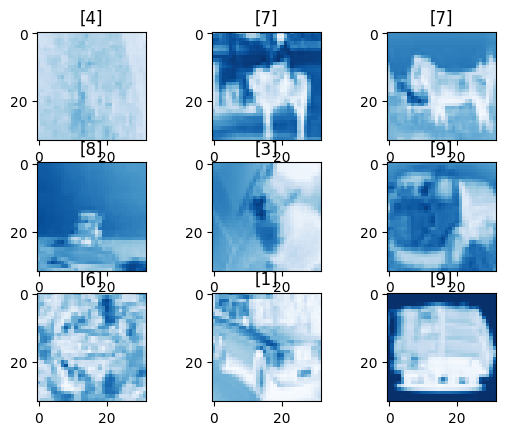

In [11]:
# TODO: Explore the data, display some input images
#!!! avec CNN+MLP il faut garder la 4ème dim sur les 3 canaux
## display dans le canal 0
from matplotlib import pyplot as plt
import numpy as np

def multiplots(X, y):
    # voir pour générer les rows randomly
    x_max = y_max = 3
    rows = [10, 11, 12, 100, 101, 102, 200,201,202] 
    fig, axs = plt.subplots(x_max, y_max)    
    
    for i in range(x_max):
        for j in range(y_max):
            row = x_max * i + j
            imag = X[rows[row]]
            imag = np.array(imag, dtype='float')
            pixels = imag.reshape((X.shape[1], X.shape[2]))
            axs[i, j].imshow(pixels, vmin=0, vmax=255, cmap='Blues')
            axs[i, j].set_title(y[rows[row]])
    
multiplots(X_train[:,:,:,0], y_train)

**Q3.** Take care of the data preparation and preprocessing: scale the data, transform the labels into the correct shape.

In [13]:
# TODO: Make the data preparation
## prendre la fcn de B.ROLAND prepare_data où??
# Rescale the data
X_train = X_train / 255.0
X_test  = X_test / 255.0

# Reshape: FAUT-IL FAIRE UN RESHAPE POUR UN CNN+MLP?? ouimais pas un flattening reshape
# c'est pour ajouter la 4ème dim sur les canaux si besoin
# ici, ce n'est pas nécessaire caar la dim est déjà présente
#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
#X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Transform the targets to categorical vectors
y_train = keras.utils.to_categorical(y_train, nb_classes)
y_test  = keras.utils.to_categorical(y_test,  nb_classes)

**Q4.** Now we will try to build a VGG model, and train it from scratch to see the performances we reach.

For complexity reasons, the VGG model has to be simplified for such a dataset, so we will only keep the first layers :

In [14]:
## code existant avec le modèle VGG16
## utilisation ici de l'API fonctionnelle pour utiliser VGG16
## le base_model est VGG16
## ensuite: on prend l'output de la dernière couche
## qui est transmise à flatten
## ie: on applique la couche flatten au résultat de la couche x
## get_layer permet de récupérer le résultat de la dernière couche
## ici en fonctionnel: on n'ajoute pas une couche avec 'add'
## include_top = False
## Déclarer la couche dense et lui passer l'output de la dernière couche de VGG16

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# create the base model BASE _MODEL
base_model = VGG16(weights=None, include_top=False, 
             input_shape=X_train.shape[1:])

# add a flattening layer
# let's add a fully-connected layer to classify
x = base_model.get_layer('block3_pool').output
x = Flatten(name='Flatten')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(nb_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

2024-06-05 16:13:12.920470: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-05 16:13:12.921076: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-05 16:13:12.921418: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (MichaelPC): /proc/driver/nvidia/version does not exist
2024-06-05 16:13:12.925174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


☝️ Have a look at this code and try to understand it, feel free to ask questions.

**Q5.** Now compile and fit your model on your training data for 10 epochs. Feel free to have a look at the architecture of your model using `.summary()`.

In [15]:
# Model overview
model.summary() ##3.8M params !! trop long à faire tourner sur mon PC

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [16]:
# TODO: Compile and fit your model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define the callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5),
    TensorBoard(log_dir="./training_logs/mnist/lenet"),
]

# Finally fit the model
model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=128,
    callbacks=callbacks,
)

Epoch 1/10
 54/391 [===>..........................] - ETA: 2:52 - loss: 2.3028 - accuracy: 0.1078

**Q6.** Now compute then the accuracy of your model.

In [5]:
# TODO: Compute the accuracy of your model
### STRIP_START ###
from sklearn.metrics import accuracy_score

y_pred_train = keras.utils.to_categorical(model.predict(X_train).argmax(axis=1), num_classes=10)
y_pred_test = keras.utils.to_categorical(model.predict(X_test).argmax(axis=1), num_classes=10)

print('accuracy on train with NN:', accuracy_score(y_pred_train, y_train))
print('accuracy on test with NN:', accuracy_score(y_pred_test, y_test))

1563/1563 [==============================] - 9s 5ms/step\
313/313 [==============================] - 1s 3ms/step\
accuracy on train with NN: 0.93738
accuracy on test with NN: 0.7669

-> Huge improvement from 0.38 on test I had before with MLP model

Did you improve your results compared to what you had a couple of days ago on this dataset? Why?

**Q7.** Now, try to redo the same, but this time you will **reuse the pretrained weights from image net**, using the parameter `weights = 'imagenet'`, and going up to the `'block4_pool'` layer, with the following code:
```python
x = base_model.get_layer('block4_pool').output
```

Do you see any improvement in the accuracy?

In [6]:
# TODO: Retrain a VGG model with pretrained weights from image net and check the accuracy
##voir le cours avec imagenet

# create the Transfer Learning Model:
transfer_learn_model = VGG16(weights='imagenet', include_top=False, 
             input_shape=X_train.shape[1:])

# add a flattening layer
# let's add a fully-connected layer to classify
x = transfer_learn_model.get_layer('block4_pool').output
##vpoir s'il faut conserver les deux layers suivantes:
x = Flatten(name='Flatten')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(nb_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=transfer_learn_model.input, outputs=predictions)

In [ ]:
# Model overview
model.summary()

In [ ]:
# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define the callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5),
    TensorBoard(log_dir="./training_logs/TransferLearning/VGG16_IMAGENET"),
]

# Finally fit the model
model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=128,
    callbacks=callbacks,
)

### demander comment trouver tensorBoard depuis un run sur Google Colab !!

le code a tourné sur Google Colab sur GPU\
bcp trop lent sur PC

1563/1563 [==============================] - 9s 5ms/step\
313/313 [==============================] - 2s 6ms/step\
accuracy on train with TransferLearning Imagenet: 0.95086\
accuracy on test with TransferLearning Imagenet: 0.808